In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

## Quantile Regression

We analyze a quantile regression model trained to predict the lower quantile $Q_{\alpha/2}$, the median $Q_{1/2}$, and the upper quantile $Q_{1-\alpha/2}$ for various datasets.

The datasets "Delaney (raw)" and "Solubility (raw)" contain the same data as "Delaney" and "Solubility", respectively, but expressed in terms of solubility rather than log-solubility.

Miscoverage levels $\alpha \in \{0.1, 0.2, 0.3, 0.4, 0.5\}$ were used for all datasets, except for the "raw" versions, for which only $\alpha = 0.3$ was used.

In [2]:
dataset_names = {
    "Clearance": "clearance_hepatocyte_az",
    "Delaney": "delaney",
    "Delaney (raw)": "delaney_raw",
    "Enamine": "enamine",
    "Freesolv": "freesolv",
    "HLM": "HLM",
    "LD50": "ld50_zhu",
    "Lipophilicity": "lipo",
    "MDR1-MDCK ER": "MDR1_MDCK_ER",
    "PPBR": "ppbr_az",
    "QM7": "qm7",
    "QM9": "qm9",
    "RLM": "RLM",
    "Solubility": "Solubility",
    "Solubility (raw)": "Solubility_raw",
    "hPPB": "hPPB",
    "rPPB": "rPPB",
}

In [3]:
datasets = {
    name: pd.read_csv(f"datasets/{code}_predictions_median.csv")
    for name, code in dataset_names.items()
}

## Quantile Crossing Analysis

This section evaluates the validity of the predicted quantile triplets by checking for **quantile crossing** when evaluating the models on holdout test sets.

Quantile crossing is a situation in which predicted quantiles violate their natural ordering:

- $Q_{\alpha/2} > Q_{1/2}$: the model predicts **lower > median**
- $Q_{1/2} > Q_{1-\alpha/2}$: the model predicts **median > upper**
- $Q_{\alpha/2} > Q_{1-\alpha/2}$: the model predicts **lower > upper**

The results are summarized in a table for each dataset and miscoverage level.

In [4]:
for name, df in datasets.items():
    df.rename(columns={df.columns[1]: "true_value"}, inplace=True)
    df["crossings"] = (
        (df["lower_quantile"] > df["median"])
        | (df["median"] > df["upper_quantile"])
        | (df["lower_quantile"] > df["upper_quantile"])
    )

In [5]:
quantile_crossings = pd.DataFrame(
    columns=[
        "dataset",
        "alpha",
        "test points",
        "lower > median",
        "median > upper",
        "lower > upper",
        "any crossing",
        "percentage",
    ]
)

no_quantile_crossings = pd.DataFrame(
    columns=[
        "dataset",
        "test points",
        "alphas",
    ]
)

no_crossings = []
for dataset_name, data in datasets.items():
    no_crossing_alphas = []
    for alpha in data["alpha"].unique():
        df = data[data["alpha"] == alpha]
        lower_gt_median = df["lower_quantile"] > df["median"]
        median_gt_upper = df["median"] > df["upper_quantile"]
        lower_gt_upper = df["lower_quantile"] > df["upper_quantile"]
        any_crossing = lower_gt_median | median_gt_upper | lower_gt_upper
        if any_crossing.sum() > 0:
            quantile_crossings.loc[len(quantile_crossings)] = {
                "dataset": dataset_name,
                "alpha": alpha,
                "test points": len(df),
                "lower > median": lower_gt_median.sum(),
                "median > upper": median_gt_upper.sum(),
                "lower > upper": lower_gt_upper.sum(),
                "any crossing": any_crossing.sum(),
                "percentage": round(100 * any_crossing.sum() / len(df),  1),
            }
        else:
            no_crossing_alphas.append(f"{alpha:.1f}")
    if no_crossing_alphas:
        no_quantile_crossings.loc[len(no_quantile_crossings)] = {
            "dataset": dataset_name,
            "test points": len(df),
            "alphas": ", ".join(no_crossing_alphas),
        }

print("Quantile Crossing Summary:")
display(quantile_crossings)
print("Cases Without Quantile Crossings:")
display(no_quantile_crossings)

Quantile Crossing Summary:


,dataset,alpha,test points,lower > median,median > upper,lower > upper,any crossing,percentage
0,Clearance,0.1,610,1,0,0,1,0.2
1,Clearance,0.2,610,6,0,0,6,1.0
2,Clearance,0.3,610,6,1,0,7,1.1
3,Clearance,0.4,610,10,1,1,11,1.8
4,Clearance,0.5,610,5,2,0,7,1.1
5,Delaney,0.1,565,0,1,0,1,0.2
6,Delaney,0.2,565,1,0,0,1,0.2
7,Delaney,0.3,565,2,2,1,4,0.7
8,Delaney,0.4,565,2,2,0,4,0.7
9,Delaney,0.5,565,19,8,5,26,4.6


Cases Without Quantile Crossings:


,dataset,test points,alphas
0,Enamine,24855,"0.1, 0.2, 0.3, 0.4, 0.5"
1,LD50,3695,"0.1, 0.2, 0.3"
2,Lipophilicity,2100,"0.1, 0.2"
3,MDR1-MDCK ER,1325,0.1
4,Solubility,1090,"0.2, 0.4"
5,hPPB,100,"0.1, 0.2, 0.3, 0.4, 0.5"
6,rPPB,85,0.1


#### Key Observations

- Quantile crossing is generally rare, with typical rates below 1–2%, though some cases reach up to ~19%.
- Increasing the miscoverage level $\alpha$ (i.e., narrowing the interquantile range) tends to increase the likelihood of crossing, as expected.
- Large datasets often exhibit no or very low crossing rates, suggesting more stable and well-ordered quantile predictions.

#### Possible Solution

To enforce quantile ordering, predict the median and two softplus-transformed offsets, which are subtracted from and added to the median to obtain the lower and upper quantiles.


## Distribution Asymmetry Analysis

In this section, we assess the asymmetry of the predictive distributions for each test point using the Groeneveld & Meeden (1984) skewness measure:

$$
S_{\alpha} = \frac{Q_{\alpha/2} + Q_{1-\alpha/2} - 2 Q_{1/2}}{Q_{1-\alpha/2} - Q_{\alpha/2}} = \frac{\text{midpoint} - \text{median}}{\text{halfwidth}}
$$

This coefficient quantifies how far the median deviates from the midpoint of the central prediction interval:
- $S_{\alpha} \approx 0$: symmetric distribution  
- $S_{\alpha} > 0$: right-skewed (median lies left of center)  
- $S_{\alpha} < 0$: left-skewed (median lies right of center)  

By definition, $S_{\alpha} \in [-1, 1]$ when the quantiles are properly ordered. Values outside this range usually indicate *quantile crossing*, though not all crossings yield invalid skewness values.

The negative of $S_{\alpha}$ reflects the position of the median relative to the interval center, scaled by half the interval width. It offers a normalized view of central tendency displacement.

**Reference:**

Groeneveld, R. A., & Meeden, G. (1984). Measuring Skewness and Kurtosis. *Journal of the Royal Statistical Society. Series D (The Statistician)*, 33(4), 391–399. [https://doi.org/10.2307/2987742](https://doi.org/10.2307/2987742)


In [6]:
dataframes = []
for name, data in datasets.items():
    df = data.copy()
    midpoint = (data["lower_quantile"] + data["upper_quantile"]) / 2
    halfwidth = (data["upper_quantile"] - data["lower_quantile"]) / 2
    df["skewness"] = (midpoint - data["median"]) / halfwidth
    df.rename(columns={df.columns[1]: "true value"}, inplace=True)
    df["dataset"] = name
    dataframes.append(df)

all_datasets = pd.concat(dataframes)

### Skewness Distributions

We compare the distributions of predicted skewness values across datasets at each miscoverage level.

Data points with predicted quantile crossings are excluded from distribution estimations and marked with red dots.

The datasets "Delaney (raw)" and "Solubility (raw)" are included in the plot for $\alpha = 0.3$.

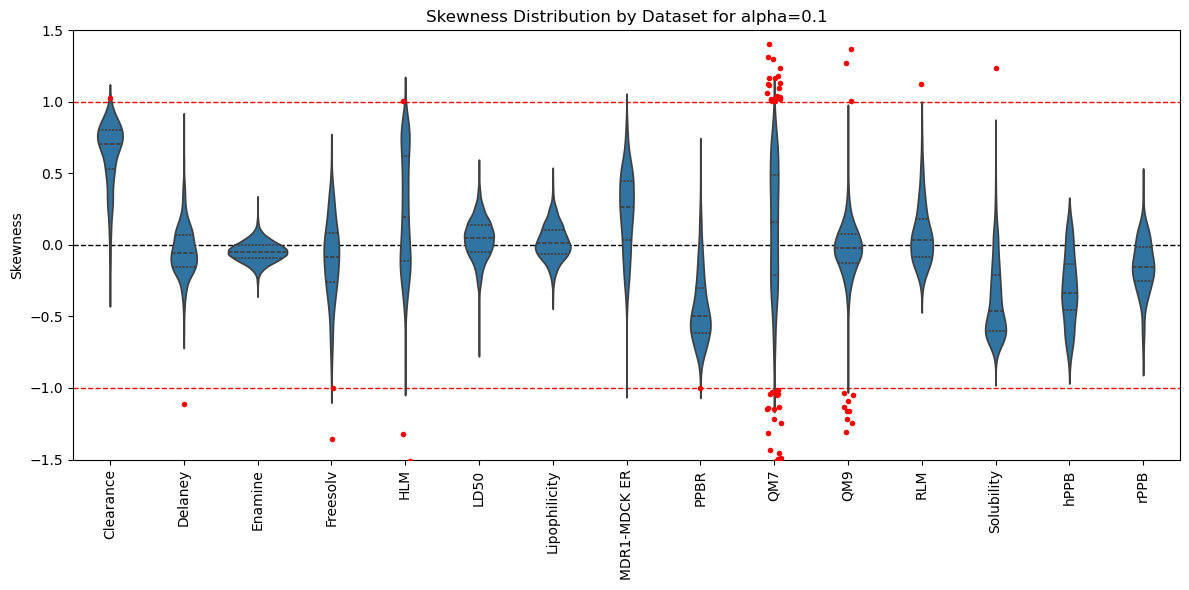

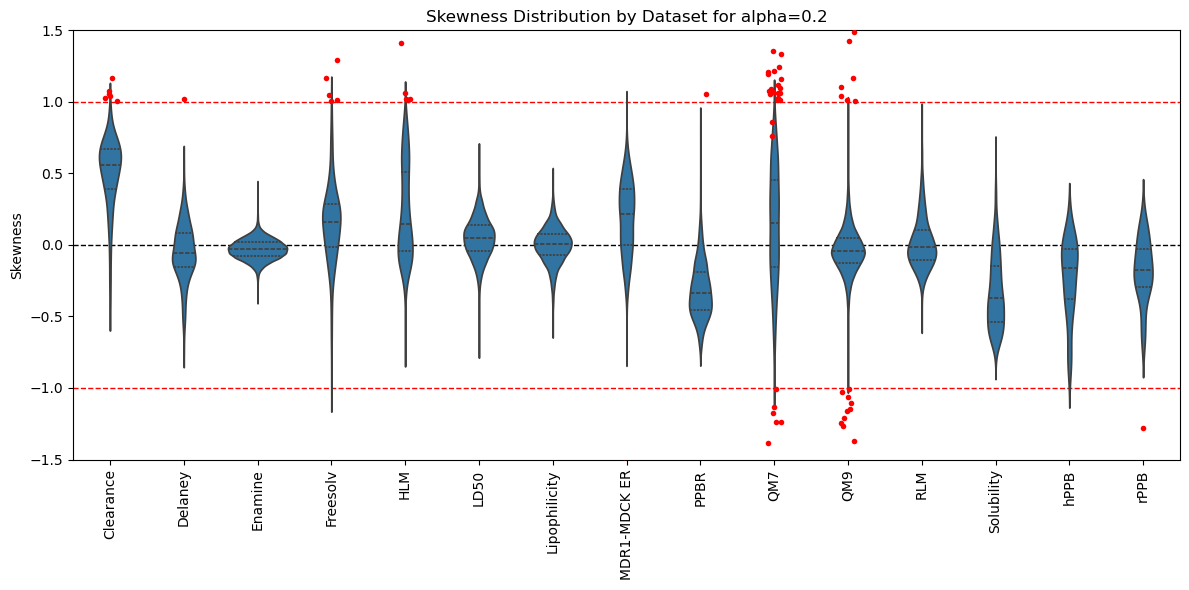

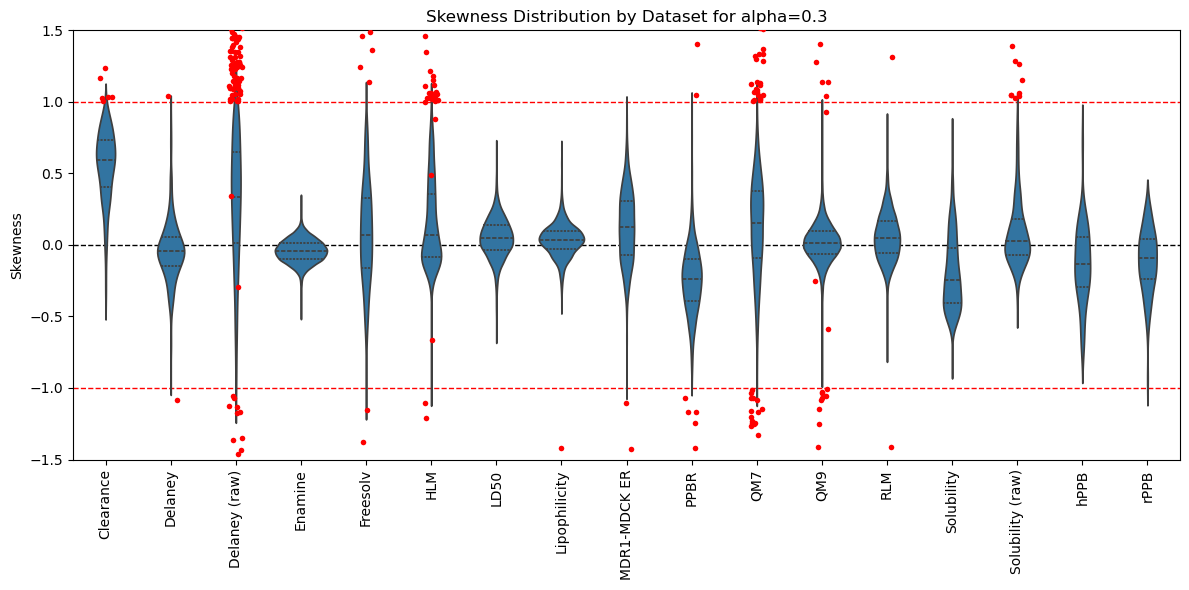

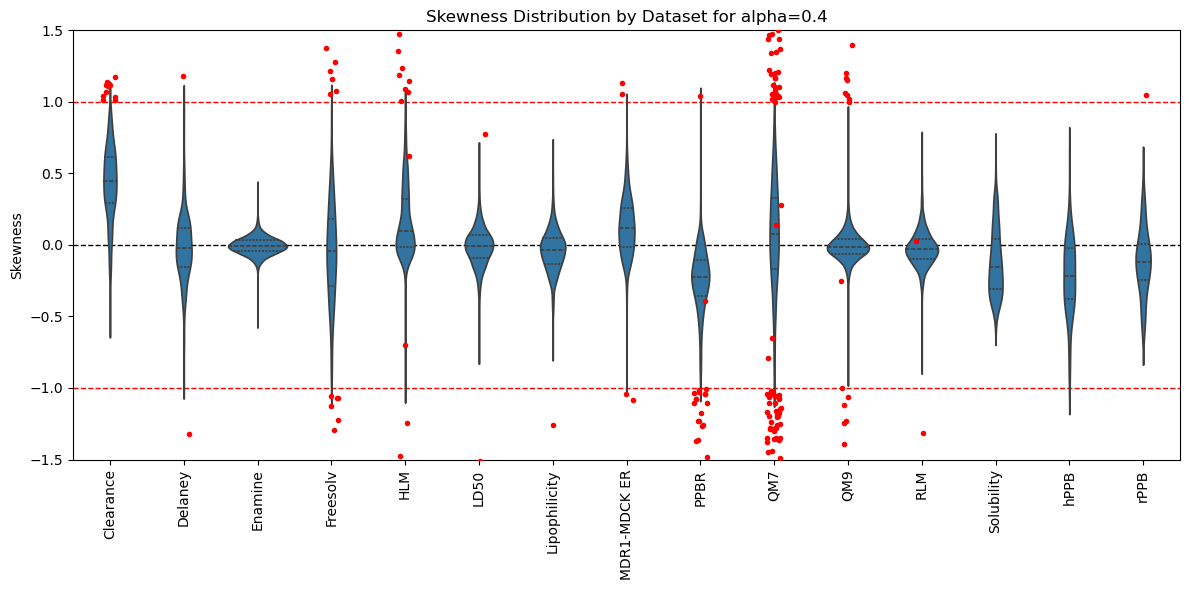

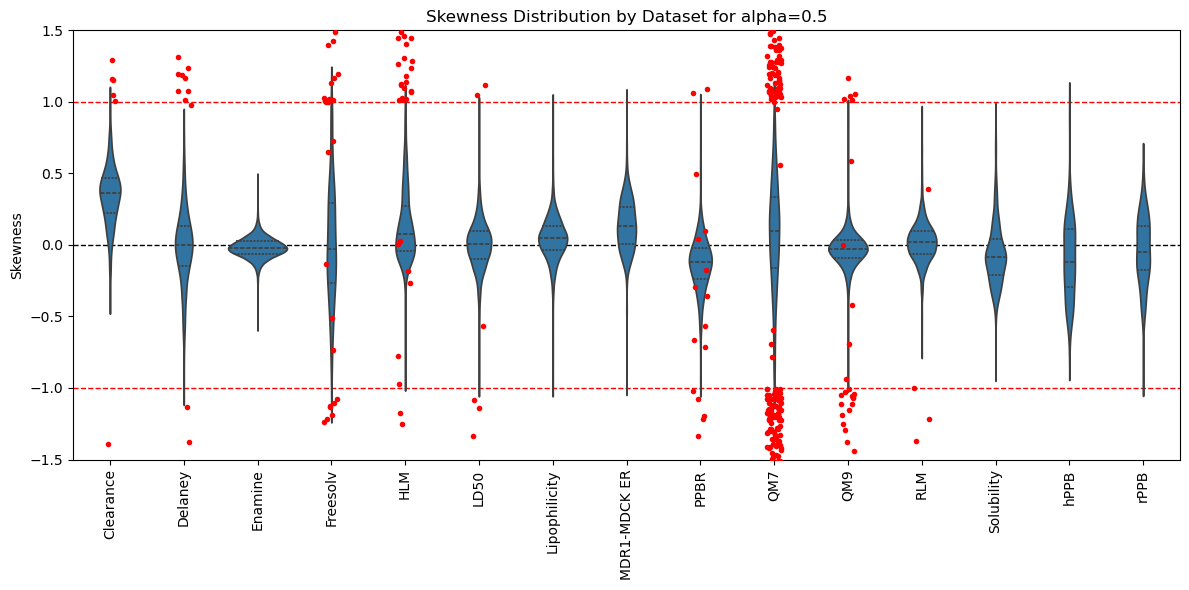

In [7]:
no_crossing = all_datasets.loc[~all_datasets["crossings"]]
with_crossing = all_datasets.loc[all_datasets["crossings"]]

for alpha in all_datasets["alpha"].unique():
    plt.figure(figsize=(12, 6))
    for y, color in zip([-1, 0, 1], ["red", "black", "red"]):
        plt.axhline(y=y, color=color, linestyle="--", linewidth=1, zorder=-1)
    sns.violinplot(
        x="dataset",
        y="skewness",
        data=no_crossing[no_crossing["alpha"] == alpha],
        inner="quartile",
    )
    sns.stripplot(
        x="dataset",
        y="skewness",
        data=with_crossing[with_crossing["alpha"] == alpha],
        color="red",
        size=4,
    )

    plt.title(f"Skewness Distribution by Dataset for alpha={alpha}")
    plt.ylabel("Skewness")
    plt.xlabel(None)
    plt.xticks(rotation=90)
    plt.ylim(-1.5, 1.5)
    plt.tight_layout()
    plt.show()

We summarize the mean skewness for each dataset at each miscoverage level in the bar plot below.

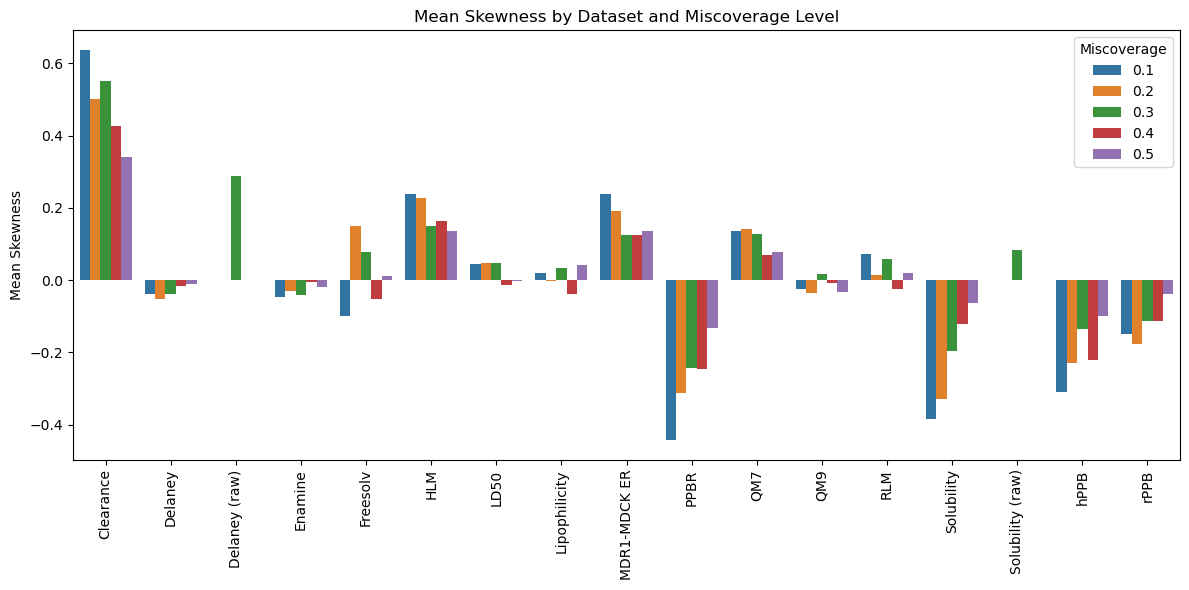

In [8]:
summary = no_crossing.groupby(["dataset", "alpha"])["skewness"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=summary,
    x="dataset",
    y="skewness",
    hue="alpha",
    palette="tab10",
)

plt.title("Mean Skewness by Dataset and Miscoverage Level")
plt.ylabel("Mean Skewness")
plt.xlabel(None)
plt.legend(title="Miscoverage", loc="upper right")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Key Observations

- **Enamine**, **LD50**, **Lipophilicity**, **QM9**, **RLM**, and **Solubility (raw)** show skewness values tightly clustered around zero, indicating highly symmetric predictive distributions (PDs).
- **Clearance** and **PPBR** - and, to a lesser extent, **Solubility** - exhibit skewness concentrated around non-zero values, suggesting consistent asymmetry.
- Other datasets display a wider skewness spread, reflecting a mix of symmetric and asymmetric PDs.
- The rise in red dots and dispersion at higher miscoverage levels supports the quantile crossing analysis, pointing to increased instability and asymmetry as intervals narrow.

## Distribution-Agnostic Calibration Analysis

This analysis assesses whether predicted quantiles align with empirical observations, without assuming any specific form for the predictive distribution.

For each dataset, we compute the proportion of test points where the true value falls below each predicted quantile. In a well-calibrated model, this empirical fraction should closely match the corresponding quantile level.

Once again, we exclude data points with predicted quantile crossings.

In [9]:
dataframes = []
for case, data in {
    "below lower": no_crossing["true value"] < no_crossing["lower_quantile"],
    "below median": no_crossing["true value"] < no_crossing["median"],
    "below upper": no_crossing["true value"] < no_crossing["upper_quantile"],
}.items():
    df = no_crossing[["dataset", "alpha"]].copy()
    df["case"] = case
    df["value"] = data
    dataframes.append(df.groupby(["dataset", "alpha", "case"])["value"].mean().reset_index())

quantile_coverage = pd.concat(dataframes)
quantile_coverage["quantile level"] = quantile_coverage.apply(
    lambda x: x["alpha"] / 2
    if x["case"] == "below lower"
    else (1 - x["alpha"] / 2 if x["case"] == "below upper" else 0.5),
    axis=1,
)

To verify calibration, we plot the empirical fraction against the quantile level and compare it to the diagonal line representing perfect calibration.

Points above the diagonal indicate that too many true values fall below the predicted quantiles—i.e., the model is overestimating the quantiles. Conversely, points below the diagonal suggest underestimation.

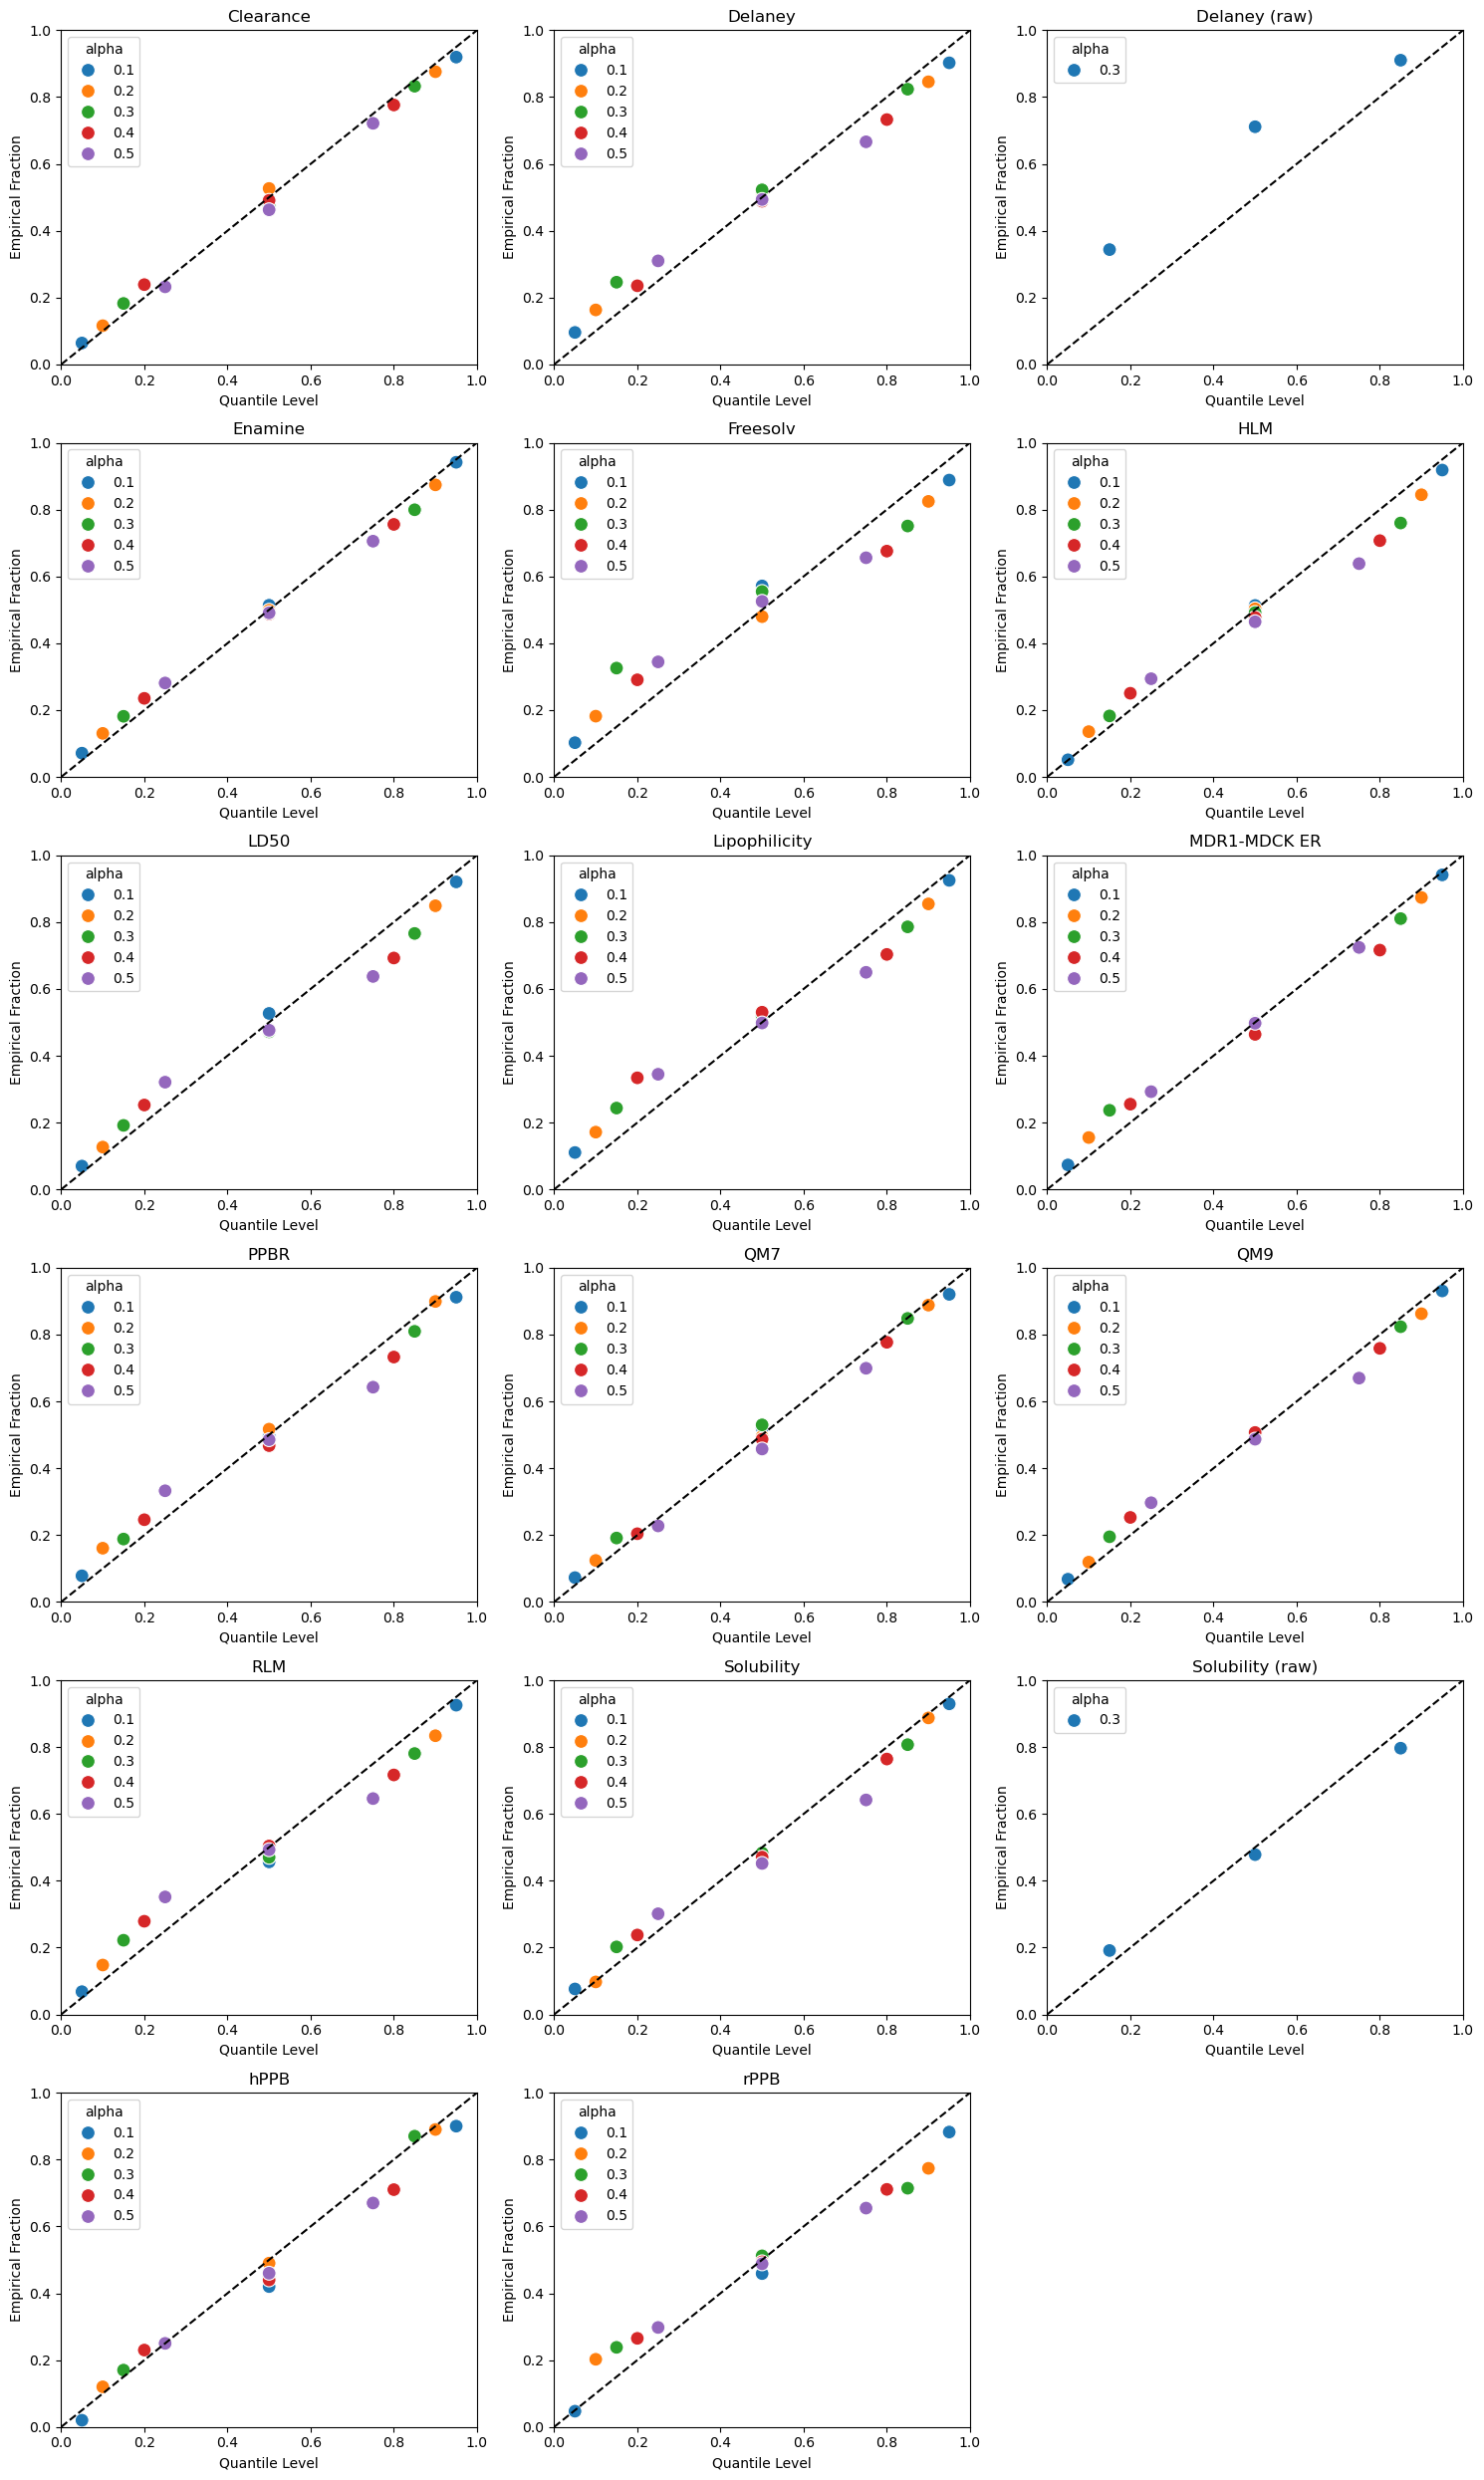

In [10]:
fig, axes = plt.subplots(6, 3, figsize=(15, 25))
axes = iter(axes.flatten())
for dataset in quantile_coverage["dataset"].unique():
    ax = next(axes)
    ax.set_title(dataset)
    df = quantile_coverage[quantile_coverage["dataset"] == dataset]
    sns.scatterplot(
        data=df,
        x="quantile level",
        y="value",
        hue="alpha",
        palette="tab10",
        ax=ax,
        s=100
    )
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Quantile Level")
    ax.set_ylabel("Empirical Fraction")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Key Observations

- Except for **Delaney (raw)**, quantile regression is well-calibrated across datasets, especially considering the no conformalization has been applied.
- The model tends to overestimate low quantiles and underestimate high ones, indicating overconfidence (prediction intervals are exceedingly narrow).
- In general, the overconfidence is more pronounced for high miscoverage levels.